In [66]:
import os
import sys
sys.path.append('src')
import numpy as np

from tqdm import tqdm
from generator import generate_samples
from utils import split_and_preprocess
from adjustment_methods import (
    get_ate_ols,
    get_ate_cuped,
    get_ate_cupac,
    get_ate_doubly_robust,
    get_ate_doubly_robust_wrong,
    doubly_robust_matheus,
)

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Using the generator to generate some samples

### With no covariates

In [67]:
data = generate_samples(
    mu_metric=5,
    sigma_metric=1,
    epsilon=2,
    treatment_effect=1,
    size=10_000,
    cov_mu_eps=[],
    non_linear=[],
    p_binomial=0.1,
    seed=0,
)
data

,Y,T,Y_before,R_1
0,1.717709,0,4.164818,-1.485954
1,6.755605,0,5.642950,0.675301
2,4.907128,0,4.847138,0.732710
3,4.820693,0,5.830693,-0.367354
4,5.246950,0,4.485035,-0.772765
...,...,...,...,...
9995,3.337901,0,3.989631,-2.209024
9996,1.945809,0,3.355647,-0.969425
9997,1.728958,0,4.310035,0.785172
9998,4.246286,0,3.839939,-0.865403


### With covariates

In [68]:
data = generate_samples(
    mu_metric=5,
    sigma_metric=1,
    epsilon=2,
    treatment_effect=2,
    size=10_000,
    cov_mu_eps=[(-1,1),(-2,1),(5,2)],
    non_linear=[False, False, True],
    p_binomial=0.5,
    seed=0,
)
data

,Y,T,Y_before,X_1,X_2,X_3,R_1
0,11.713374,0,6.255290,-1.231625,-2.041732,2.994389,-0.541784
1,1.333936,1,5.383194,-2.042249,-0.572580,1.009924,1.318836
2,21.619884,1,4.882116,-1.597580,-3.674115,4.689426,0.620458
3,116.566588,1,6.632311,-1.578616,-2.057696,10.480307,1.447373
4,18.820626,1,6.117096,0.088830,-1.686580,3.170425,0.396254
...,...,...,...,...,...,...,...
9995,19.245299,1,2.336245,-0.341360,-3.407202,4.119529,0.423050
9996,9.510129,0,7.111079,-1.994824,-0.650428,2.394617,-0.073036
9997,24.787707,1,4.021791,-3.218242,-0.852646,4.579803,-0.089729
9998,65.072293,0,4.295076,-1.230111,-2.063770,7.930710,1.240147


# Getting a single ATE for this data

In [69]:
train_data, test_data = split_and_preprocess(data, treatment_effect=2)
len(train_data), len(test_data)

(5000, 5000)

# Mean Diff

In [70]:
test_data.loc[test_data['T']==1, 'Y'].mean() - test_data.loc[test_data['T']==0, 'Y'].mean()

1.2496105681724359

### CUPED

Only uses outcome pre experiment

In [71]:
get_ate_cuped(test_data)

1.2444229268229705

### Multivariable regression

In [72]:
get_ate_ols(test_data, covariates=["Y_before", "X_1", "X_2", "X_3"])

1.7469319863798023

### CUPAC

In [73]:
get_ate_cupac(test_data, train_data, covariates=["Y_before", "X_1", "X_2", "X_3"])

2.0120660099440677

### Doubly Robust

In [74]:
get_ate_doubly_robust(test_data, covariates=["Y_before", "X_1", "X_2", "X_3"])

/Users/davidmasip/Documents/Workspace/covariate-adjustment-blogpost/src/adjustment_methods.py:46: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  predictions_control = pd.Series(index=data.index)
/Users/davidmasip/Documents/Workspace/covariate-adjustment-blogpost/src/adjustment_methods.py:47: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  predictions_treatment = pd.Series(index=data.index)


1.9234027577181472

## Simulating the experiment many times, supposing only linear effects

$$\epsilon \sim N(0,2)$$
$$Y_0 \sim N(20,10)$$
$$X_1 \sim N(-1,-1)$$
$$X_2 \sim N(-2,1)$$
$$X_3 \sim N(5,5)$$

$$Y = Y_0 + 0.1*T + X_1 + X_2 + X_3 + \epsilon$$

100%|██████████| 50/50 [03:33<00:00,  4.27s/it]


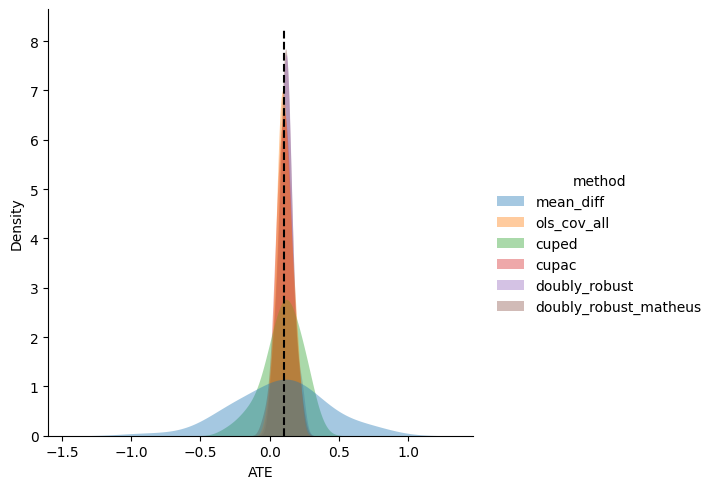

,method,mse
0,cupac,0.002995
1,cuped,0.018276
2,doubly_robust,0.002815
3,doubly_robust_matheus,0.002384
4,mean_diff,0.108919
5,ols_cov_all,0.002653


In [76]:
ate = []
ate_cuped = []
ate_ols_cov = []
ate_cupac = []
ate_doubly_robust = []
ate_doubly_robust_wrong = []
ate_doubly_robust_matheus = []

N_SAMPLES = 10_000
N_SIMULATIONS = 50
REAL_ATE = 0.1

for i in tqdm(range(N_SIMULATIONS)):
    data = generate_samples(
        mu_metric=20,
        sigma_metric=10,
        epsilon=2,
        treatment_effect=REAL_ATE,
        size=N_SAMPLES,
        cov_mu_eps=[(-1,1),(-2,1),(5,5)],
    )

    pre_analysis_data, analysis_data = split_and_preprocess(data, REAL_ATE)
    ate_cupac.append(get_ate_cupac(analysis_data, pre_analysis_data, covariates=['Y_before', 'X_1', 'X_2', 'X_3']))
    ate.append(analysis_data.loc[analysis_data['T']==1, 'Y'].mean() - analysis_data.loc[analysis_data['T']==0, 'Y'].mean())
    ate_ols_cov.append(get_ate_ols(analysis_data, covariates=['Y_before', 'X_1', 'X_2', 'X_3']))
    ate_cuped.append(get_ate_cuped(analysis_data))
    ate_doubly_robust.append(get_ate_doubly_robust(analysis_data, covariates=['Y_before', 'X_1', 'X_2', 'X_3']))
    # ate_doubly_robust_wrong.append(get_ate_doubly_robust_wrong(analysis_data, covariates=['Y_before', 'X_1', 'X_2', 'X_3']))
    ate_doubly_robust_matheus.append(doubly_robust_matheus(analysis_data, covariates=['Y_before', 'X_1', 'X_2', 'X_3']))

results = pd.DataFrame({
    'mean_diff': ate,
    'ols_cov_all': ate_ols_cov,
    'cuped': ate_cuped,
    'cupac': ate_cupac,
    'doubly_robust': ate_doubly_robust,
    # 'doubly_robust_wrong': ate_doubly_robust_wrong,
    'doubly_robust_matheus': ate_doubly_robust_matheus,
}).stack(level=0).reset_index(level=1, name='ATE').rename({'level_1': 'method'}, axis=1).reset_index(drop=True)
errors = pd.DataFrame({
    'mean_diff': (np.array(ate) - REAL_ATE)**2,
    'ols_cov_all': (np.array(ate_ols_cov) - REAL_ATE)**2,
    'cuped': (np.array(ate_cuped) - REAL_ATE)**2,
    'cupac': (np.array(ate_cupac) - REAL_ATE)**2,
    'doubly_robust': (np.array(ate_doubly_robust) - REAL_ATE)**2,
    # 'doubly_robust_wrong': (np.array(ate_doubly_robust_wrong) - REAL_ATE)**2,
    'doubly_robust_matheus': (np.array(ate_doubly_robust_matheus) - REAL_ATE)**2,
}).stack(level=0).reset_index(level=1, name='ATE').rename({'level_1': 'method'}, axis=1).reset_index(drop=True)


sns.displot(x='ATE',data=results, fill=True, kind='kde', hue='method', common_norm=False, alpha=.4, linewidth=0, bw_adjust=1.2);
plt.vlines(REAL_ATE, plt.ylim()[0], plt.ylim()[1], linestyles="dashed", label='ATE',colors='k');
plt.show()
errors.groupby('method').agg(mse=('ATE', 'mean')).reset_index()

In [ ]:
# analysis_data['T'].value_counts()

1    2532
0    2468
Name: T, dtype: int64

## Now simulating the same linear process, but using only a random variable as a covariate

In [ ]:
ate = []
ate_cuped = []
ate_ols_cov = []
ate_cupac = []
ate_doubly_robust = []

N_SAMPLES = 100_000
N_SIMULATIONS = 100
REAL_ATE = 0.1

for i in range(N_SIMULATIONS):
    data = generate_samples(
        mu_metric=20,
        sigma_metric=10,
        epsilon=2,
        treatment_effect=REAL_ATE,
        size=N_SAMPLES,
        cov_mu_eps=[(-1,1),(-2,1),(5,2)],
    )

    pre_analysis_data, analysis_data = split_and_preprocess(data, REAL_ATE)
    ate_cupac.append(get_ate_cupac(analysis_data, pre_analysis_data, covariates=['R_1']))
    ate.append(analysis_data.loc[analysis_data['T']==1, 'Y'].mean() - analysis_data.loc[analysis_data['T']==0, 'Y'].mean())
    ate_ols_cov.append(get_ate_ols(analysis_data, covariates=['R_1']))
    ate_cuped.append(get_ate_cuped(analysis_data, prediction_column='R_1'))
    ate_doubly_robust.append(get_ate_doubly_robust(analysis_data, covariates=['R_1']))

results = pd.DataFrame({
    'mean_diff': ate,
    'ols_cov_all': ate_ols_cov,
    'cuped': ate_cuped,
    'cupac': ate_cupac,
    'doubly_robust': ate_doubly_robust,
}).stack(level=0).reset_index(level=1, name='ATE').rename({'level_1': 'method'}, axis=1).reset_index(drop=True)
errors = pd.DataFrame({
    'mean_diff': (np.array(ate) - REAL_ATE)**2,
    'ols_cov_all': (np.array(ate_ols_cov) - REAL_ATE)**2,
    'cuped': (np.array(ate_cuped) - REAL_ATE)**2,
    'cupac': (np.array(ate_cupac) - REAL_ATE)**2,
    'doubly_robust': (np.array(ate_doubly_robust) - REAL_ATE)**2,
}).stack(level=0).reset_index(level=1, name='ATE').rename({'level_1': 'method'}, axis=1).reset_index(drop=True)


sns.displot(x='ATE',data=results, fill=True, kind='kde', hue='method', common_norm=False, alpha=.4, linewidth=0, bw_adjust=1.2);
plt.vlines(REAL_ATE, plt.ylim()[0], plt.ylim()[1], linestyles="dashed", label='ATE',colors='k');
plt.show()
errors.groupby('method').agg(mse=('ATE', 'mean')).reset_index()

## Simulating now with non-linear effects

$$\epsilon \sim N(0,2)$$
$$Y_0 \sim N(20,10)$$
$$X_1 \sim N(-1,-1)$$
$$X_2 \sim N(-2,1)$$
$$X_3 \sim N(5,5)$$

$$Y = Y_0 + 0.1*T + X_1 + X_2 + X_3^2 + \epsilon$$

In [ ]:
ate = []
ate_cuped = []
ate_ols_cov = []
ate_cupac = []
ate_doubly_robust = []

N_SAMPLES = 100_000
N_SIMULATIONS = 100
REAL_ATE = 0.1

for i in range(N_SIMULATIONS):
    data = generate_samples(
        mu_metric=20,
        sigma_metric=10,
        epsilon=2,
        treatment_effect=REAL_ATE,
        size=N_SAMPLES,
        cov_mu_eps=[(-1,1),(-2,1),(5,5)],
        non_linear=[False, False, True]
    )

    pre_analysis_data, analysis_data = split_and_preprocess(data, REAL_ATE)
    ate_cupac.append(get_ate_cupac(analysis_data, pre_analysis_data, covariates=['Y_before', 'X_1', 'X_2', 'X_3']))
    ate.append(analysis_data.loc[analysis_data['T']==1, 'Y'].mean() - analysis_data.loc[analysis_data['T']==0, 'Y'].mean())
    ate_ols_cov.append(get_ate_ols(analysis_data, covariates=['Y_before', 'X_1', 'X_2', 'X_3']))
    ate_cuped.append(get_ate_cuped(analysis_data))
    ate_doubly_robust.append(get_ate_doubly_robust(analysis_data, covariates=['Y_before', 'X_1', 'X_2', 'X_3']))

results = pd.DataFrame({
    'mean_diff': ate,
    'ols_cov_all': ate_ols_cov,
    'cuped': ate_cuped,
    'cupac': ate_cupac,
    'doubly_robust': ate_doubly_robust,
}).stack(level=0).reset_index(level=1, name='ATE').rename({'level_1': 'method'}, axis=1).reset_index(drop=True)
errors = pd.DataFrame({
    'mean_diff': (np.array(ate) - REAL_ATE)**2,
    'ols_cov_all': (np.array(ate_ols_cov) - REAL_ATE)**2,
    'cuped': (np.array(ate_cuped) - REAL_ATE)**2,
    'cupac': (np.array(ate_cupac) - REAL_ATE)**2,
    'doubly_robust': (np.array(ate_doubly_robust) - REAL_ATE)**2,
}).stack(level=0).reset_index(level=1, name='ATE').rename({'level_1': 'method'}, axis=1).reset_index(drop=True)


sns.displot(x='ATE',data=results, fill=True, kind='kde', hue='method', common_norm=False, alpha=.4, linewidth=0, bw_adjust=1.2);
plt.vlines(REAL_ATE, plt.ylim()[0], plt.ylim()[1], linestyles="dashed", label='ATE',colors='k');
plt.show()
errors.groupby('method').agg(mse=('ATE', 'mean')).reset_index()